# Monk Notebook

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.network import NeuralNetwork
from model.trainer import Trainer
from model.losses import Loss
from utils import DataLoader
from utils import load_monk, plot_curves
from utils.model_selection_helpers import instability_coeff, tran_val_diff, count_parameters
from model.activations import sigmoid

np.random.seed(8) #reproducibility

In [2]:
# All the configurations to test for the training
# Neural Network architectures
INPUT_NEURONS = 17
OUTPUT_NEURONS = 1

HIDDEN_LAYER_SIZES = [4, 8]
HIDDEN_LAYERS_COUNTS = [1, 2]
INTERNAL_ACTIVATIONS = ['tanh', 'leaky relu', 'relu']
OUTPUT_ACTIVATIONS_AND_LOSS = [('sigmoid', 'mse'), ('identity', 'binary cross entropy sigmoid')]
NEURAL_NETWORK_CONFIGURATIONS = []

for hidden_layers_count in HIDDEN_LAYERS_COUNTS:
    for hidden_layer_size in HIDDEN_LAYER_SIZES:
        for internal_activation in INTERNAL_ACTIVATIONS:
            for output_activation, loss_function in OUTPUT_ACTIVATIONS_AND_LOSS:
                architecture = [INPUT_NEURONS] + [hidden_layer_size] * hidden_layers_count + [OUTPUT_NEURONS]
                activations = [internal_activation] * hidden_layers_count + [output_activation]
                NEURAL_NETWORK_CONFIGURATIONS.append((architecture, activations, loss_function))

# Training parameters
ETA_CONFIGURATIONS = [0.01, 0.001, 0.0005]
LAMBDA_CONFIGURATIONS = [0, 1e-4, 1e-5, 1e-6] # we have to make them small because they are independent of eta
ALPHA_CONFIGURATIONS = [0, 0.5, 0.9]
BATCH_SIZES = [16, 32]

# Cross-validation parameters
K_FOLDS= 5
EPOCHS = 250
EARLY_STOPPING_PATIENCE = 50

# All possible configurations are tuples (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE)
CONFIGURATIONS = []

for NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F in NEURAL_NETWORK_CONFIGURATIONS:
  for ETA in ETA_CONFIGURATIONS:
    for LAMBDA in LAMBDA_CONFIGURATIONS:
      for ALPHA in ALPHA_CONFIGURATIONS:
        for BATCH_SIZE in BATCH_SIZES:
            config = (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE)
            CONFIGURATIONS.append(config)
LEN_CONFIGURATIONS = len(CONFIGURATIONS)

print(f"Total configurations: {LEN_CONFIGURATIONS}")

Total configurations: 1728


## Monk 1

In [3]:
# Here we load the dataset and create k folds
PATH_TRAIN = 'data/monk/monks-1.train'
PATH_TEST = 'data/monk/monks-1.test'
X_train_full, y_train_full, X_test, y_test = load_monk(PATH_TRAIN, PATH_TEST)
monk_dataset_1 = DataLoader(X_train_full, y_train_full)
k_fold = monk_dataset_1.k_fold(k = K_FOLDS)

# Here we create dictionaries for storing avg accuracies and epochs on k folds and other metrics, we will use them to select the best configuration
CONFIG_DICTIONARY, CONFIG_DICTIONARY_EPOCHS, CONFIG_DICTIONARY_INSTABILITY_TRAIN, CONFIG_DICTIONARY_INSTABILITY_VAL, CONFIG_DICTIONARY_TRAIN_LOSS_DIFF = {}, {}, {}, {}, {}
for i in range(LEN_CONFIGURATIONS):
  CONFIG_DICTIONARY[i], CONFIG_DICTIONARY_EPOCHS[i], CONFIG_DICTIONARY_INSTABILITY_TRAIN[i], CONFIG_DICTIONARY_INSTABILITY_VAL[i], CONFIG_DICTIONARY_TRAIN_LOSS_DIFF[i] = 0, 0, 0, 0, 0

# Cross Validation X K-folds
for i in range(LEN_CONFIGURATIONS): #iterate over all configurations
  print(f"Training {i+1}/{LEN_CONFIGURATIONS}")
  config = CONFIGURATIONS[i]
  
  for X_train, y_train, X_val, y_val in k_fold: #iterate over k folds
    NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = config
    print(f"NEURAL_NETWORK_ARCHITECTURE: {NEURAL_NETWORK_ARCHITECTURE}, NEURAL_NETWORK_ACTIVATION: {NEURAL_NETWORK_ACTIVATION}, LOSS_F: {LOSS_F}, ETA: {ETA}, LAMBDA: {LAMBDA}, ALPHA: {ALPHA}, BATCH_SIZE: {BATCH_SIZE}")
    
    #train
    nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
    trainer = Trainer(
        nn=nn,
        loss=Loss(LOSS_F),
        X_train=X_train,
        y_train=y_train, 
        X_val=X_val,
        y_val=y_val,
        epochs=EPOCHS,
        early_stopping=EARLY_STOPPING_PATIENCE, # no improvements (implicitly greater than 5%) in 50 epochs-> stop
        eta=ETA,                   # Learning rate iniziale
        lam=LAMBDA,                # L2
        alpha=ALPHA,               # Momentum
        batch_size=BATCH_SIZE,
        shuffle_batches=True
    )
    best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False) # returns the best nn based on val, the train and val loss vectors
    CONFIG_DICTIONARY_EPOCHS[i] += len(train_loss_vector) #number of epochs until early stopping or max epochs
    CONFIG_DICTIONARY_INSTABILITY_TRAIN[i] += instability_coeff(train_loss_vector)
    CONFIG_DICTIONARY_INSTABILITY_VAL[i] += instability_coeff(test_loss_vector)
    CONFIG_DICTIONARY_TRAIN_LOSS_DIFF[i] += tran_val_diff(train_loss_vector, test_loss_vector)
    #best val accuracy
    out = best_nn.forward(X_val)[-1][-1]
    if LOSS_F == 'binary cross entropy sigmoid':
      out = sigmoid(out)
    predictions = np.round(out)
    print(f"Accuracy: {np.mean(predictions == y_val) * 100}%")
    CONFIG_DICTIONARY[i] += np.mean(predictions == y_val)

After one-hot encoding: X train full shape: (124, 17), X test shape: (432, 17), y train full shape: (124, 1), y test shape: (432, 1)
Training 1/1728
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 68.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 100.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 66.66666666666666%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 88.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 84.0%
Training 2/1

In [4]:
# print the top 25 configurations, sorting criterias: 1 avg accuracy, 2 n parameters (the less the better), 3 instability coeff (the less the better)
TOP_25_CONFIGS_INDEXES = sorted(CONFIG_DICTIONARY, key=lambda i: (-CONFIG_DICTIONARY[i], count_parameters(CONFIGURATIONS[i][0]), (CONFIG_DICTIONARY_INSTABILITY_VAL[i] + CONFIG_DICTIONARY_INSTABILITY_TRAIN[i]) / K_FOLDS))[:25]
print("Top 5 configurations:")
for i in TOP_25_CONFIGS_INDEXES:
    ACCURACY = CONFIG_DICTIONARY[i] * 100 / K_FOLDS
    print(f'''Config index: {CONFIGURATIONS[i]}, Avg Epochs: {CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS}, Mean Accuracy: {ACCURACY}%,
           training instability coeff validation: {CONFIG_DICTIONARY_INSTABILITY_VAL[i] / K_FOLDS}, 
           training instability coeff train: {CONFIG_DICTIONARY_INSTABILITY_TRAIN[i] / K_FOLDS}, 
           training loss-val loss diff: {CONFIG_DICTIONARY_TRAIN_LOSS_DIFF[i] / K_FOLDS}, 
           Mean Epochs: {CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS}''')

Top 5 configurations:
Config index: ([17, 4, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0, 0.9, 16), Avg Epochs: 250, Mean Accuracy: 100.0%,
           training instability coeff validation: 0.5537336571010942, 
           training instability coeff train: 1.627195811844775, 
           training loss-val loss diff: 5.341749367202227, 
           Mean Epochs: 250
Config index: ([17, 4, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 1e-06, 0.9, 16), Avg Epochs: 250, Mean Accuracy: 100.0%,
           training instability coeff validation: 0.7512002969975619, 
           training instability coeff train: 1.5548945976715636, 
           training loss-val loss diff: 6.878075072813372, 
           Mean Epochs: 250
Config index: ([17, 4, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.0001, 0.9, 32), Avg Epochs: 184, Mean Accuracy: 100.0%,
           training instability coeff validation: 1.1336599483267382, 
           training instabili

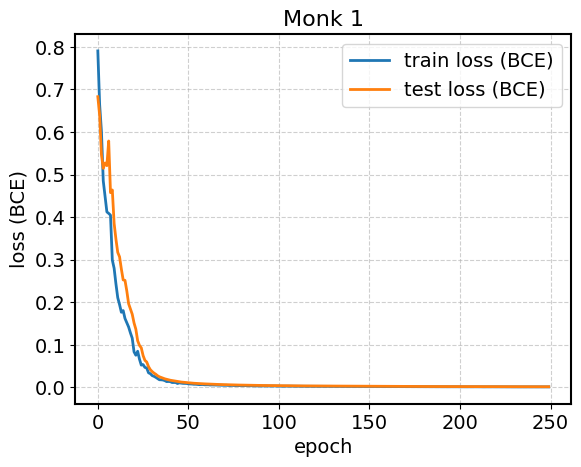

Accuracy: 100.0%


In [5]:
### chosen configuration
'''Config index: ([17, 4, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0, 0.9, 16), Avg Epochs: 250, Mean Accuracy: 100.0%,
           training instability coeff validation: 0.5537336571010942, 
           training instability coeff train: 1.627195811844775, 
           training loss-val loss diff: 5.341749367202227, 
           Mean Epochs: 250'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [17, 4, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0, 0.9, 16
EPOCHS = 250

nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_full,
    y_train=y_train_full,
    X_val = X_test,
    y_val=y_test,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False)

#plot curves
plot_curves(train_loss_vector, test_loss_vector, 'loss (BCE)', 'test', title = 'Monk 1', save_plots=True)

# val accuracy, we can't early stop because we are using the test set as final evaluation, we can't pick the best nn, we have to use the last nn
out = nn.forward(X_test)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Accuracy: {np.mean(predictions == y_test) * 100}%")

## Monk 2

In [6]:
# Here we load the dataset and create k folds
PATH_TRAIN = 'data/monk/monks-2.train'
PATH_TEST = 'data/monk/monks-2.test'
X_train_full, y_train_full, X_test, y_test = load_monk(PATH_TRAIN, PATH_TEST)
monk_dataset_2 = DataLoader(X_train_full, y_train_full)
k_fold = monk_dataset_2.k_fold(k = K_FOLDS)

# Here we create dictionaries for storing avg accuracies and epochs on k folds and other metrics, we will use them to select the best configuration
CONFIG_DICTIONARY, CONFIG_DICTIONARY_EPOCHS, CONFIG_DICTIONARY_INSTABILITY_TRAIN, CONFIG_DICTIONARY_INSTABILITY_VAL, CONFIG_DICTIONARY_TRAIN_LOSS_DIFF = {}, {}, {}, {}, {}
for i in range(LEN_CONFIGURATIONS):
  CONFIG_DICTIONARY[i], CONFIG_DICTIONARY_EPOCHS[i], CONFIG_DICTIONARY_INSTABILITY_TRAIN[i], CONFIG_DICTIONARY_INSTABILITY_VAL[i], CONFIG_DICTIONARY_TRAIN_LOSS_DIFF[i] = 0, 0, 0, 0, 0
  
# Cross Validation X K-folds
for i in range(LEN_CONFIGURATIONS): #iterate over all configurations
  print(f"Training {i+1}/{LEN_CONFIGURATIONS}")
  config = CONFIGURATIONS[i]
  
  for X_train, y_train, X_val, y_val in k_fold: #iterate over k folds
    NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = config
    print(f"NEURAL_NETWORK_ARCHITECTURE: {NEURAL_NETWORK_ARCHITECTURE}, NEURAL_NETWORK_ACTIVATION: {NEURAL_NETWORK_ACTIVATION}, LOSS_F: {LOSS_F}, ETA: {ETA}, LAMBDA: {LAMBDA}, ALPHA: {ALPHA}, BATCH_SIZE: {BATCH_SIZE}")
    
    #train
    nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
    trainer = Trainer(
        nn=nn,
        loss=Loss(LOSS_F),
        X_train=X_train,
        y_train=y_train, 
        X_val=X_val,
        y_val=y_val,
        epochs=EPOCHS,
        early_stopping=EARLY_STOPPING_PATIENCE,
        eta=ETA,                   # Learning rate iniziale
        lam=LAMBDA,                # L2
        alpha=ALPHA,               # Momentum
        batch_size=BATCH_SIZE,
        shuffle_batches=True
    )
    best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False) # returns the best nn based on val, the train and val loss vectors
    CONFIG_DICTIONARY_EPOCHS[i] += len(train_loss_vector) #number of epochs until early stopping or max epochs
    CONFIG_DICTIONARY_INSTABILITY_TRAIN[i] += instability_coeff(train_loss_vector)
    CONFIG_DICTIONARY_INSTABILITY_VAL[i] += instability_coeff(test_loss_vector)
    CONFIG_DICTIONARY_TRAIN_LOSS_DIFF[i] += tran_val_diff(train_loss_vector, test_loss_vector)

    #best val accuracy
    out = best_nn.forward(X_val)[-1][-1]
    if LOSS_F == 'binary cross entropy sigmoid':
      out = sigmoid(out)
    predictions = np.round(out)
    print(f"Accuracy: {np.mean(predictions == y_val) * 100}%")
    CONFIG_DICTIONARY[i] += np.mean(predictions == y_val)

After one-hot encoding: X train full shape: (169, 17), X test shape: (432, 17), y train full shape: (169, 1), y test shape: (432, 1)
Training 1/1728
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 55.88235294117647%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 58.82352941176471%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 51.515151515151516%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 55.88235294117647%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATC

In [7]:
# print the top 25 configurations, sorting criterias: 1 avg accuracy, 2 n parameters (the less the better), 3 instability coeff (the less the better)
TOP_25_CONFIGS_INDEXES = sorted(CONFIG_DICTIONARY, key=lambda i: (-CONFIG_DICTIONARY[i], count_parameters(CONFIGURATIONS[i][0]), CONFIG_DICTIONARY_INSTABILITY_VAL[i] / K_FOLDS))[:25]
print("Top 5 configurations:")
for i in TOP_25_CONFIGS_INDEXES:
    ACCURACY = CONFIG_DICTIONARY[i] * 100 / K_FOLDS
    print(f'''Config index: {CONFIGURATIONS[i]}, Avg Epochs: {CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS}, Mean Accuracy: {ACCURACY}%,
           training instability coeff validation: {CONFIG_DICTIONARY_INSTABILITY_VAL[i] / K_FOLDS}, 
           training instability coeff train: {CONFIG_DICTIONARY_INSTABILITY_TRAIN[i] / K_FOLDS}, 
           training loss-val loss diff: {CONFIG_DICTIONARY_TRAIN_LOSS_DIFF[i] / K_FOLDS}, 
           Mean Epochs: {CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS}''')

Top 5 configurations:
Config index: ([17, 4, 1], ['relu', 'identity'], 'binary cross entropy sigmoid', 0.001, 1e-06, 0.9, 32), Avg Epochs: 250, Mean Accuracy: 100.0%,
           training instability coeff validation: 0.02676654267217147, 
           training instability coeff train: 1.2241059678114745, 
           training loss-val loss diff: 4.849274572371554, 
           Mean Epochs: 250
Config index: ([17, 4, 1], ['leaky relu', 'identity'], 'binary cross entropy sigmoid', 0.001, 1e-05, 0.9, 16), Avg Epochs: 250, Mean Accuracy: 100.0%,
           training instability coeff validation: 0.04857384357688655, 
           training instability coeff train: 1.0774421475178237, 
           training loss-val loss diff: 6.164153933353512, 
           Mean Epochs: 250
Config index: ([17, 4, 1], ['relu', 'sigmoid'], 'mse', 0.01, 1e-05, 0.5, 16), Avg Epochs: 250, Mean Accuracy: 100.0%,
           training instability coeff validation: 0.05389547041201218, 
           training instability coeff tr

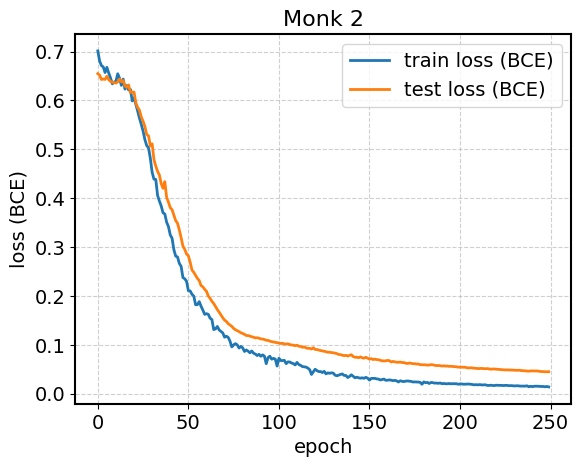

Accuracy: 98.37962962962963%


In [10]:
### chosen configuration
'''Config index: ([17, 4, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0, 0.5, 16), Avg Epochs: 250, Mean Accuracy: 100.0%,
           training instability coeff validation: 0.05803281372574217, 
           training instability coeff train: 0.5671509669352708, 
           training loss-val loss diff: 5.935130543542388, 
           Mean Epochs: 250'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [17, 4, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0, 0.5, 16
EPOCHS = 250

nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_full,
    y_train=y_train_full,
    X_val = X_test,
    y_val=y_test,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False)

#plot curves
plot_curves(train_loss_vector, test_loss_vector, 'loss (BCE)', 'test', title = 'Monk 2', save_plots=True)

# val accuracy, we can't early stop because we are using the test set as final evaluation, we can't pick the best nn, we have to use the last nn
out = nn.forward(X_test)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Accuracy: {np.mean(predictions == y_test) * 100}%")

## Monk 3

In [11]:
# Here we load the dataset and create k folds
PATH_TRAIN = 'data/monk/monks-3.train'
PATH_TEST = 'data/monk/monks-3.test'
X_train_full, y_train_full, X_test, y_test = load_monk(PATH_TRAIN, PATH_TEST)
monk_dataset_3 = DataLoader(X_train_full, y_train_full)
k_fold = monk_dataset_3.k_fold(k = K_FOLDS)

# Here we create dictionaries for storing avg accuracies and epochs on k folds and other metrics, we will use them to select the best configuration
CONFIG_DICTIONARY, CONFIG_DICTIONARY_EPOCHS, CONFIG_DICTIONARY_INSTABILITY_TRAIN, CONFIG_DICTIONARY_INSTABILITY_VAL, CONFIG_DICTIONARY_TRAIN_LOSS_DIFF, CONFIG_FINAL_LOSS = {}, {}, {}, {}, {}, {}
for i in range(LEN_CONFIGURATIONS):
  CONFIG_DICTIONARY[i], CONFIG_DICTIONARY_EPOCHS[i], CONFIG_DICTIONARY_INSTABILITY_TRAIN[i], CONFIG_DICTIONARY_INSTABILITY_VAL[i], CONFIG_DICTIONARY_TRAIN_LOSS_DIFF[i], CONFIG_FINAL_LOSS[i] = 0, 0, 0, 0, 0, 0

  
# Cross Validation X K-folds
for i in range(LEN_CONFIGURATIONS): #iterate over all configurations
  print(f"Training {i+1}/{LEN_CONFIGURATIONS}")
  config = CONFIGURATIONS[i]
  
  for X_train, y_train, X_val, y_val in k_fold: #iterate over k folds
    NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = config
    print(f"NEURAL_NETWORK_ARCHITECTURE: {NEURAL_NETWORK_ARCHITECTURE}, NEURAL_NETWORK_ACTIVATION: {NEURAL_NETWORK_ACTIVATION}, LOSS_F: {LOSS_F}, ETA: {ETA}, LAMBDA: {LAMBDA}, ALPHA: {ALPHA}, BATCH_SIZE: {BATCH_SIZE}")
    
    #train
    nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
    trainer = Trainer(
        nn=nn,
        loss=Loss(LOSS_F),
        X_train=X_train,
        y_train=y_train, 
        X_val=X_val,
        y_val=y_val,
        epochs=EPOCHS,
        early_stopping=EARLY_STOPPING_PATIENCE,
        eta=ETA,                   # Learning rate iniziale
        lam=LAMBDA,                # L2
        alpha=ALPHA,               # Momentum
        batch_size=BATCH_SIZE,
        shuffle_batches=True
    )
    best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False) # returns the best nn based on val, the train and val loss vectors
    CONFIG_DICTIONARY_EPOCHS[i] += len(train_loss_vector) #number of epochs until early stopping or max epochs
    CONFIG_DICTIONARY_INSTABILITY_TRAIN[i] += instability_coeff(train_loss_vector)
    CONFIG_DICTIONARY_INSTABILITY_VAL[i] += instability_coeff(test_loss_vector)
    CONFIG_DICTIONARY_TRAIN_LOSS_DIFF[i] += tran_val_diff(train_loss_vector, test_loss_vector)
    CONFIG_FINAL_LOSS[i] += train_loss_vector[-1]

    #best val accuracy
    out = best_nn.forward(X_val)[-1][-1]
    if LOSS_F == 'binary cross entropy sigmoid':
      out = sigmoid(out)
    predictions = np.round(out)
    print(f"Accuracy: {np.mean(predictions == y_val) * 100}%")
    CONFIG_DICTIONARY[i] += np.mean(predictions == y_val)

After one-hot encoding: X train full shape: (122, 17), X test shape: (432, 17), y train full shape: (122, 1), y test shape: (432, 1)
Training 1/1728
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 91.66666666666666%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 80.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 100.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 100.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 4, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0, BATCH_SIZE: 16
Accuracy: 95.83333333333334

In [12]:
# print the top 25 configurations, sorting criterias: 1 avg accuracy every mean acc > 92.5 is set to 92.5 in order to be able to value other parameters, 2 n parameters (the less the better), 3 instability coeff (the less the better)
# we want to prioritize simple & stable models 
TOP_25_CONFIGS_INDEXES = sorted(CONFIG_DICTIONARY, key=lambda i: (- min(92.5, CONFIG_DICTIONARY[i]* 100 / K_FOLDS), count_parameters(CONFIGURATIONS[i][0]), (CONFIG_DICTIONARY_INSTABILITY_VAL[i] + CONFIG_DICTIONARY_INSTABILITY_TRAIN[i])))[:25]
print("Top 5 configurations:")
for i in TOP_25_CONFIGS_INDEXES:
    ACCURACY = CONFIG_DICTIONARY[i] * 100 / K_FOLDS
    print(f'''Config index: {CONFIGURATIONS[i]}, Avg Epochs: {CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS}, Mean Accuracy: {ACCURACY}%,
           training instability coeff validation: {CONFIG_DICTIONARY_INSTABILITY_VAL[i] / K_FOLDS}, 
           training instability coeff train: {CONFIG_DICTIONARY_INSTABILITY_TRAIN[i] / K_FOLDS}, 
           training loss-val loss diff: {CONFIG_DICTIONARY_TRAIN_LOSS_DIFF[i] / K_FOLDS}, 
           Mean Epochs: {CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS}''')

Top 5 configurations:
Config index: ([17, 4, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.0005, 0.0001, 0.9, 16), Avg Epochs: 111, Mean Accuracy: 93.5%,
           training instability coeff validation: 0.061495981215401785, 
           training instability coeff train: 0.3884795175611332, 
           training loss-val loss diff: 10.241645738275626, 
           Mean Epochs: 111
Config index: ([17, 4, 1], ['leaky relu', 'sigmoid'], 'mse', 0.0005, 0.0001, 0.9, 16), Avg Epochs: 159, Mean Accuracy: 93.5%,
           training instability coeff validation: 0.008454214632810132, 
           training instability coeff train: 0.5104071244610746, 
           training loss-val loss diff: 3.9811413230008954, 
           Mean Epochs: 159
Config index: ([17, 4, 1], ['tanh', 'sigmoid'], 'mse', 0.001, 0.0001, 0.9, 16), Avg Epochs: 118, Mean Accuracy: 93.5%,
           training instability coeff validation: 0.04699458727096436, 
           training instability coeff train: 0.523959504629

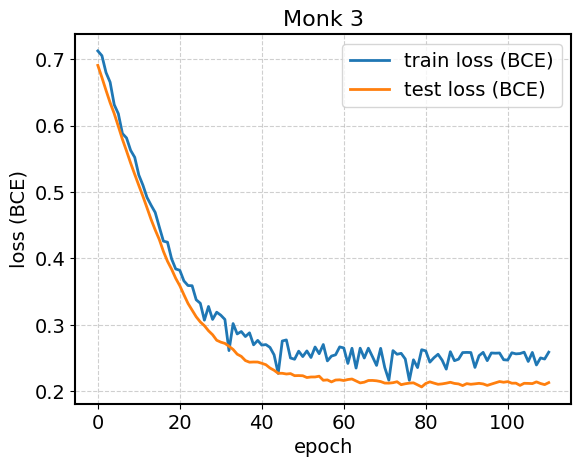

Accuracy: 97.22222222222221%


In [17]:
### chosen configuration
'''Config index: ([17, 4, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.0005, 0.0001, 0.9, 16), Avg Epochs: 111, Mean Accuracy: 93.5%,
           training instability coeff validation: 0.061495981215401785, 
           training instability coeff train: 0.3884795175611332, 
           training loss-val loss diff: 10.241645738275626, 
           Mean Epochs: 111
'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [17, 4, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.0005, 0.0001, 0.9, 16
EPOCHS = 111

nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_full,
    y_train=y_train_full,
    X_val = X_test,
    y_val=y_test,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False)

#plot curves
plot_curves(train_loss_vector, test_loss_vector, 'loss (BCE)', 'test', title = 'Monk 3', save_plots=True)

# val accuracy, we can't early stop because we are using the test set as final evaluation, we can't pick the best nn, we have to use the last nn
out = nn.forward(X_test)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Accuracy: {np.mean(predictions == y_test) * 100}%")

## Monk 3 no reg

In [14]:
# print the top 25 configurations that overfit, we want to get the least train loss possible 
TOP_25_CONFIGS_INDEXES = sorted(CONFIG_DICTIONARY, key=lambda i: ( CONFIG_FINAL_LOSS[i] / K_FOLDS, count_parameters(CONFIGURATIONS[i][0]), (CONFIG_DICTIONARY_INSTABILITY_VAL[i] + CONFIG_DICTIONARY_INSTABILITY_TRAIN[i])))[:25]
print("Top 5 configurations:")
for i in TOP_25_CONFIGS_INDEXES:
    ACCURACY = CONFIG_DICTIONARY[i] * 100 / K_FOLDS
    print(f'''Config index: {CONFIGURATIONS[i]}, Avg Epochs: {CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS}, Mean Accuracy: {ACCURACY}%,
           training instability coeff validation: {CONFIG_DICTIONARY_INSTABILITY_VAL[i] / K_FOLDS}, 
           training instability coeff train: {CONFIG_DICTIONARY_INSTABILITY_TRAIN[i] / K_FOLDS}, 
           training loss-val loss diff: {CONFIG_DICTIONARY_TRAIN_LOSS_DIFF[i] / K_FOLDS}, 
           Mean Epochs: {CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS}''')

Top 5 configurations:
Config index: ([17, 8, 8, 1], ['leaky relu', 'leaky relu', 'identity'], 'binary cross entropy sigmoid', 0.01, 1e-06, 0.9, 16), Avg Epochs: 96, Mean Accuracy: 92.63333333333334%,
           training instability coeff validation: 6.377725296741711, 
           training instability coeff train: 6.811707203284596, 
           training loss-val loss diff: 25.56861500445634, 
           Mean Epochs: 96
Config index: ([17, 8, 8, 1], ['leaky relu', 'leaky relu', 'identity'], 'binary cross entropy sigmoid', 0.01, 1e-06, 0.9, 32), Avg Epochs: 100, Mean Accuracy: 93.5%,
           training instability coeff validation: 6.942575150578747, 
           training instability coeff train: 3.1935528385008753, 
           training loss-val loss diff: 29.77263357658394, 
           Mean Epochs: 100
Config index: ([17, 8, 8, 1], ['tanh', 'tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 1e-06, 0.9, 16), Avg Epochs: 125, Mean Accuracy: 91.9%,
           training instability co

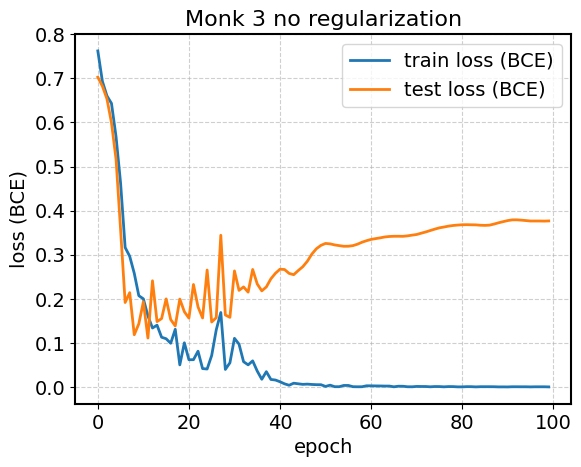

Train Accuracy: 100.0%
Test Accuracy: 94.21296296296296%


In [16]:
### chosen overfitting configuration
'''Config index: ([17, 8, 8, 1], ['leaky relu', 'leaky relu', 'identity'], 'binary cross entropy sigmoid', 0.01, 1e-06, 0.9, 32), Avg Epochs: 100, Mean Accuracy: 93.5%,
           training instability coeff validation: 6.942575150578747, 
           training instability coeff train: 3.1935528385008753, 
           training loss-val loss diff: 29.77263357658394, 
           Mean Epochs: 100
'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [17, 8, 8, 1], ['leaky relu', 'leaky relu', 'identity'], 'binary cross entropy sigmoid', 0.01, 0, 0.9, 32
EPOCHS = 100

nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_full,
    y_train=y_train_full,
    X_val = X_test,
    y_val=y_test,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False)

#plot curves
plot_curves(train_loss_vector, test_loss_vector, 'loss (BCE)', 'test', title = 'Monk 3 no regularization', save_plots=True)

# train accuracy
out = nn.forward(X_train_full)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Train Accuracy: {np.mean(predictions == y_train_full) * 100}%")

# val accuracy, we can't early stop because we are using the test set as final evaluation, we can't pick the best nn, we have to use the last nn
out = nn.forward(X_test)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Test Accuracy: {np.mean(predictions == y_test) * 100}%")